In [0]:
# http://pytorch.org/

from copy import deepcopy

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.autograd import Variable
from torch.nn import init
from torch.optim import Adam, SGD
import torch.nn as nn
import numpy as np
from scipy.signal import savgol_filter

from scipy.signal import savgol_filter

from torch.optim import Adam, SGD

import matplotlib.pyplot as plt
%matplotlib inline

device = "cpu"
if device == "cpu":
    from torch import FloatTensor
else:
    from torch.cuda import FloatTensor

    100% |████████████████████████████████| 91.1MB 45.8MB/s 
    100% |████████████████████████████████| 2.0MB 6.5MB/s 
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [0]:
import copy

import torch


def differentiable_gradient_step(module, loss, step_size, inplace=False):
    """A differentiable loss-minimizing gradient descent step on module parameters.
    Args:
        module: Perform gradient descent on parameters of this module.
            A `torch.nn.Module`.
        loss: The loss to minimize.
        step_size: The gradient descent step size.
        inplace: If true, modifies `module` in place. Otherwise, creates and
            returns a copy.
    Returns:
        module: The module with updated parameters after gradient descent.
            The original module object if `inplace` is True otherwise a copy.
    Warning:
        The output module parameters are turned into tensors.
        The Module class tries to disallow this so there might be some
        negative consequences. Be cautious when using the result.
    """
    gradients = torch.autograd.grad(loss, module.parameters(), create_graph=True, allow_unused=True)

    if not inplace:
        module = copy.deepcopy(module)

    for (param_name, param), gradient in zip(module.named_parameters(), gradients):
        name_parts = param_name.split(".")
        submodule = module
        for part in name_parts[:-1]:
            submodule = getattr(submodule, part)
        # Modules do not allow assigning variables to parameters.
        # Instead we have to directly modify the private _parameters dict.
        # This might cause other problems but at least it works for gradients.
        if gradient is not None:
          submodule._parameters[name_parts[-1]] = param - step_size * gradient
    return module

  
  

In [0]:
def weights_init(m, std):
  vals = list(m.parameters())[0]
  vals.data.normal_(0.0, std)
  
def printnetwork():
  numvals = 30
  x_range = 5
  results = np.zeros((numvals, numvals))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      results[x, y ] = nn.Softmax(0)( agent_b(  torch.tensor([-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range] )) )[0] # prob of agent B cooperating given agent A's policy 
  plt.imshow(results.T,cmap = 'jet', origin='lower')
  ax = plt.gca()
  ax.set_xticks(np.arange(0, numvals+1,numvals//5))
  ax.set_yticks(np.arange(0, numvals+1,numvals//5))
  ax.set_xticklabels(np.arange(-5, 6, 2))
  ax.set_yticklabels(np.arange(-5, 6, 2))
  # plt.xticks(ticks)
  plt.colorbar()
  

  None
      # vals = list(agent_a.parameters())[0]
# vals.data = 

In [0]:
# Batch it like you mean it.

def printnetwork():
  numvals = 25
  x_range = 5
  results = np.zeros((numvals, numvals))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      results[x, y ] = nn.Softmax(0)( agent_b(  torch.tensor([-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range] )) )[0] # prob of agent B cooperating given agentA's policy
  plt.imshow(results.T,cmap = 'jet', origin='lower')
  ax = plt.gca()
  ax.set_xticks(np.arange(0, numvals+1,numvals//5))
  ax.set_yticks(np.arange(0, numvals+1,numvals//5))
  ax.set_xticklabels(np.arange(-5, 6, 2))
  ax.set_yticklabels(np.arange(-5, 6, 2))
  # plt.xticks(ticks)
  plt.colorbar()

  None
  

plt.figure(figsize = (30,10))
t=True; f=False
stop_grad = f
cooperative = f
dbg = f
torch.manual_seed(1)
training_eps = 2000 #8000
n_inner_opt_a = 0 #1 == Agent A is LOLA
n_inner_opt_b = 20 #1 == Agent B is LOLA, number of look ahead steps
lr_b = 0.005  #outer loop learning rate for agent B
lr_a = 10     #outer loop learning rate for agent A (also used in inner loop)
std = 3   # standard deviation of policy of agent A
lr_in = lr_a
batchsize = 1 # how many different agent A's do we train on in parallel

agent_a = nn.Sequential(
    nn.Linear(batchsize, 2),
)

agent_b = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
    nn.Linear(32, 2)
)
lrs = [lr_a, lr_b ]

# decide on optimizers for the two agents.
ops = [SGD, Adam]

# PD payouts.
payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)
for i, net in enumerate([agent_a, agent_b]):
  net.optimizer = ops[i](net.parameters(), lr=lrs[i])

# Make it cooperative if you want to
if cooperative:
  payout = (payout + torch.transpose( payout,0,1))/2

# convenience function to get the returns. Calculates the expected payout for agent A and B given the policies of the agents.  
def get_return(agent_a, agent_b, overwrite = None):
  if overwrite is not None:
    batchsize = overwrite.data.numpy().shape[0]
#   print(weights_a)
    weights_a = overwrite
    agent_a_in_b = overwrite
  else:
    weights_a = list(agent_a.parameters())[0].transpose(1,0)
    batchsize = weights_a.data.numpy().shape[0]
  if stop_grad:
    agent_a_in_b = weights_a.clone().detach()
  else:
    agent_a_in_b = weights_a
  pi_b = nn.Softmax(1)( agent_b(  agent_a_in_b ) ) # prob of agent B cooperating given agent A's policy 
  rews = torch.tensor([[0.0, 0.0]]*batchsize )
  for u_b in [0,1]:
    p_u_b = pi_b[:,u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[:,u_b],weights_a[:,u_b] * 0)))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[:,0]+= prob * payout[ u_a, u_b]    
      rews[:,1]+= prob * payout[ u_b, u_a]
  return -rews

# 
def printagentaval():
  plt.figure(figsize=(12,6))
  numvals = 100
  x_range = 5
  results = np.zeros((numvals, numvals, 2))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      overwrite = torch.tensor([[-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range]] )
      results[x, y ] =  -get_return(agent_a, agent_b, overwrite = overwrite).data 
#       results[x, y ] = nn.Softmax(0)( agent_b( ) )[0] # prob of agent B cooperating given agent A's policy 
  titles = ['A', 'B']
  for i in range( 2 ):
    plt.subplot(1,2, i + 1)
    plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 101,20))
    ax.set_yticks(np.arange(0, 101,20))
    ax.set_xticklabels(np.arange(-5, 6, 2))
    ax.set_yticklabels(np.arange(-5, 6, 2))
  # plt.xticks(ticks)
    plt.colorbar()
    plt.title(titles[i])

def LOLA_step(net1, net2_, agent_a, n_inner_opt):
    # net2_ = inner agent
    # net1 = outer agent
    # Inner optimization
    agent_b = (agent_a + 1) % 2 
    outer_agent = agent_a
    inner_agent = (outer_agent+ 1) % 2 
    nets = [ net1, net2_ ]
    net_a = nets[agent_a]
    net_b = nets[agent_b]
    # Warning: This is kind of weird - doing the .sum() below is only valid for agent A in the lookahead step
    for k in range(n_inner_opt):
        objective2 = get_return(net_a, net_b)[:,inner_agent].sum()
        differentiable_gradient_step(net2_, objective2, lr_in, inplace=True)
    # Outer optimization
    objective1 = get_return(net_a, net_b)[:,outer_agent].mean()
    net1.optimizer.zero_grad()
    objective1.backward()
    net1.optimizer.step()
res = []   
for update in range(training_eps):
    if  update % (training_eps// 12) == 0:
      if 1 + (update // (training_eps// 12)) < 13:
        plt.subplot(2, 6,  1 + (update // (training_eps// 12)) )
        printnetwork()

    weights_init(agent_a, std)
    net1 = agent_a
    net2 = agent_b
    if n_inner_opt_a + n_inner_opt_b > 0:
      net2_ = deepcopy(net2).to(device)
      net1_ = deepcopy(net1).to(device)
    else:
      net2_ = net2 #deepcopy(net2).to(device)
      net1_ = net1 #deepcopy(net1).to(device)
    if dbg:
      print('before, ', list(agent_a.parameters())[0][0])
    LOLA_step(net1, net2_, 0, n_inner_opt_a)
    if dbg:
      print('after, ', list(agent_a.parameters())[0][0])
    LOLA_step(net2, net1_, 1, n_inner_opt_b )   
    
    rews = -get_return(agent_a, agent_b).mean(0)
    res.append( rews.data.numpy())
    
labels = ['nolola', 'lola']
plt.savefig('batched_LAH_' +str(n_inner_opt_b) +'_LRA_' + str(lr_a) + '.pdf' )


x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

if False:
  plt.plot(savgol_filter(x_a, 51, 3), 'r', label='Agent_a')
  plt.plot(savgol_filter(x_b, 51, 3), 'b', label='Agent_b')
  plt.legend()
  None

vals = training_eps // 2
x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

print('agent_a ret ', np.mean(x_a[vals:]))
print('agent_b ret ', np.mean(x_b[vals:]))
# plt.figure(figsize = (5,5))
# # printnetwork()
None

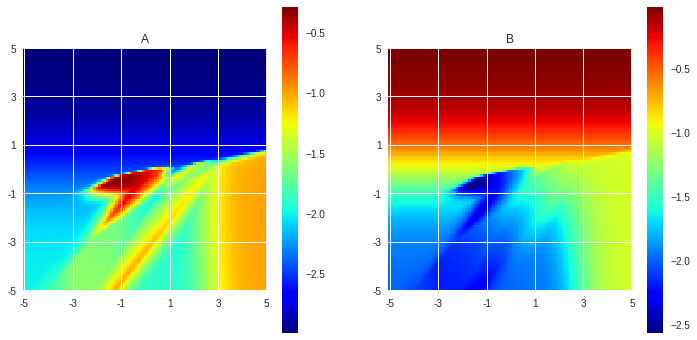

In [0]:
# def printagentaval():
#   plt.figure(figsize=(12,6))
#   numvals = 100
#   x_range = 5
#   results = np.zeros((numvals, numvals, 2))
#   ticks = []
#   for x in range(numvals):
#     ticks.append( -x_range + x/numvals*2*x_range)
#     for y in range(numvals):
#       overwrite = torch.tensor([[-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range]] )
#       results[x, y ] =  -get_return(agent_a, agent_b, overwrite = overwrite).data 
#   titles = ['A', 'B']
#   for i in range( 2 ):
#     plt.subplot(1,2, i + 1)
#     plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
#     ax = plt.gca()
#     ax.set_xticks(np.arange(0, 101,20))
#     ax.set_yticks(np.arange(0, 101,20))
#     ax.set_xticklabels(np.arange(-5, 6, 2))
#     ax.set_yticklabels(np.arange(-5, 6, 2))
#     plt.colorbar()
#     plt.title(titles[i])
printagentaval()
# -get_return(agent_a, agent_b, overwrite = overwrite) 

0
833
1666
2499
3332
4165
4998
5831
6664
7497
8330
9163
9996
agent_a ret  -2.2010348
agent_b ret  -0.91785294


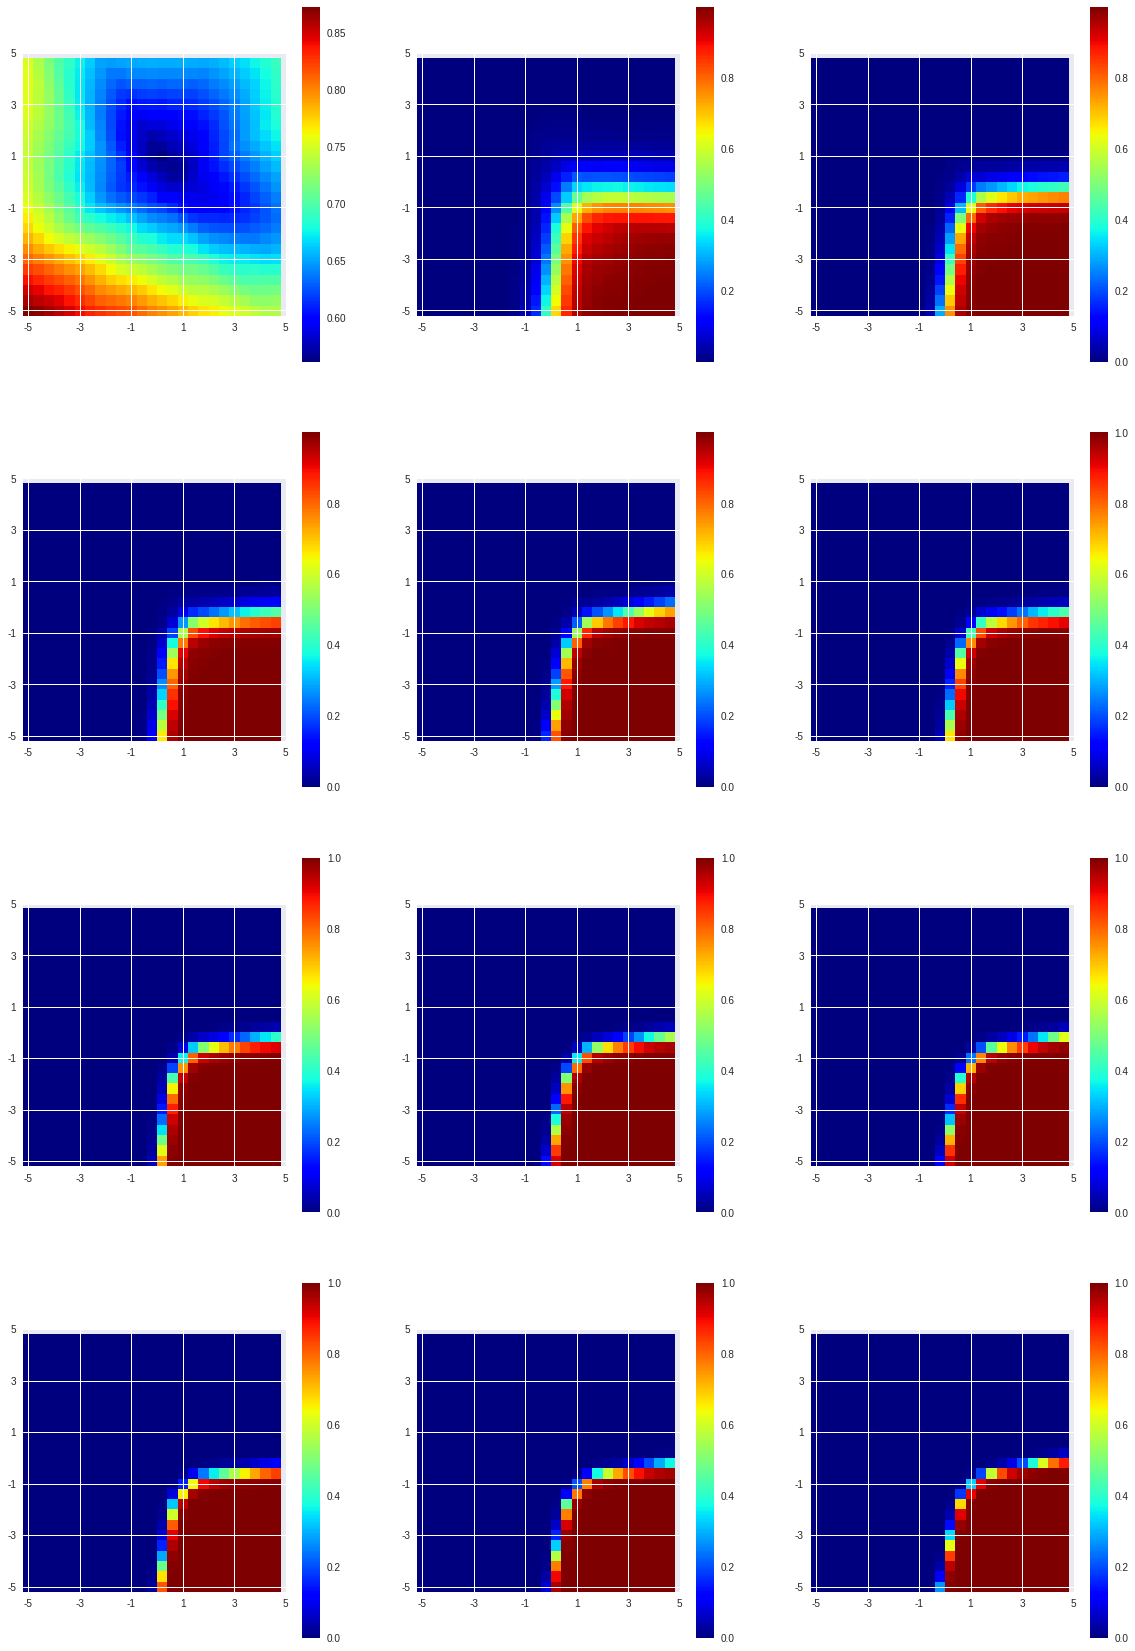

In [0]:
# Best response training w/ and w/o LOLA. Awesome stuff.
plt.figure(figsize = (20,30))
t=True; f=False
stop_grad = f
cooperative = f
dbg = f
torch.manual_seed(3)
learners = [0,1]
training_eps = 10000 #8000
n_inner_opt_a = 0 #1 == Agent A is LOLA
n_inner_opt_b = 0 #1 == Agent B is LOLA
lr_b = 0.0005
lr_a = 1.0
std = 3
lr_in = lr_a
agent_a = nn.Sequential(
    nn.Linear(2, 1),
)

agent_b = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
)
lrs = [lr_a, lr_b ]
ops = [SGD, Adam]
payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)
printnetwork()
for i, net in enumerate([agent_a, agent_b]):
  net.optimizer = ops[i](net.parameters(), lr=lrs[i])

# Make it cooperative if you want to
if cooperative:
  payout = (payout + torch.transpose( payout,0,1))/2

def get_return(agent_a, agent_b, overwrite = None):
  
  if overwrite is not None:
#   print(weights_a)
    weights_a = overwrite
    agent_a_in_b = overwrite
  else:
    weights_a = list(agent_a.parameters())[0][0]
    if stop_grad:
      agent_a_in_b = weights_a.clone().detach()
    else:
      agent_a_in_b = weights_a
  pi_b = nn.Softmax(0)( agent_b(  agent_a_in_b ) ) # prob of agent B cooperating given agent A's policy 
  rews = torch.tensor([0.0, 0.0] )
  for u_b in [0,1]:
    p_u_b = pi_b[u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[u_b],weights_a[u_b] * 0)))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[0]+= prob * payout[ u_a, u_b]    
      rews[1]+= prob * payout[ u_b, u_a]
  return -rews

def printagentaval():
  plt.figure(figsize=(12,6))
  numvals = 100
  x_range = 5
  results = np.zeros((numvals, numvals, 2))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      overwrite = torch.tensor([-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range] )
      results[x, y ] =  -get_return(agent_a, agent_b, overwrite = overwrite).data 
#       results[x, y ] = nn.Softmax(0)( agent_b( ) )[0] # prob of agent B cooperating given agent A's policy 
  titles = ['A', 'B']
  for i in range( 2 ):
    plt.subplot(1,2, i + 1)
    plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 101,20))
    ax.set_yticks(np.arange(0, 101,20))
    ax.set_xticklabels(np.arange(-5, 6, 2))
    ax.set_yticklabels(np.arange(-5, 6, 2))
  # plt.xticks(ticks)
    plt.colorbar()
    plt.title(titles[i])

def LOLA_step(net1, net2_, agent_a, n_inner_opt):
    # net2_ = inner agent
    # net1 = outer agent
    # Inner optimization
    agent_b = (agent_a + 1) % 2 
    outer_agent = agent_a
    inner_agent = (outer_agent+ 1) % 2 
    nets = [ net1, net2_ ]
    net_a = nets[agent_a]
    net_b = nets[agent_b]
    for k in range(n_inner_opt):
        objective2 = get_return(net_a, net_b)[inner_agent]
        differentiable_gradient_step(net2_, objective2, lr_in, inplace=True)
    # Outer optimization
    objective1 = get_return(net_a, net_b)[outer_agent]
    net1.optimizer.zero_grad()
    objective1.backward()
    net1.optimizer.step()
res = []   
for update in range(training_eps):
    if  update % (training_eps// 12) == 0:
      print(update)
      if 1 + (update // (training_eps// 12)) < 13:
        plt.subplot(4, 3,  1 + (update // (training_eps// 12)) )
        printnetwork()

    weights_init(agent_a, std)
    net1 = agent_a
    net2 = agent_b
    if n_inner_opt_a + n_inner_opt_b > 0:
      net2_ = deepcopy(net2).to(device)
      net1_ = deepcopy(net1).to(device)
    else:
      net2_ = net2 #deepcopy(net2).to(device)
      net1_ = net1 #deepcopy(net1).to(device)
    if dbg:
      print('before, ', list(agent_a.parameters())[0][0])
    LOLA_step(net1, net2_, 0, n_inner_opt_a)
    if dbg:
      print('after, ', list(agent_a.parameters())[0][0])
    LOLA_step(net2, net1_, 1, n_inner_opt_b )   
    
    rews = -get_return(agent_a, agent_b)
    res.append( rews.data.numpy())
    
labels = ['nolola', 'lola']
plt.savefig('policy_LAH_' +str(n_inner_opt_b) +'_LRA_' + str(lr_a) + '.pdf' )
# results:

x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

if False:
  plt.plot(savgol_filter(x_a, 51, 3), 'r', label='Agent_a')
  plt.plot(savgol_filter(x_b, 51, 3), 'b', label='Agent_b')
  plt.legend()
  None

vals = training_eps // 2
x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

print('agent_a ret ', np.mean(x_a[vals:]))
print('agent_b ret ', np.mean(x_b[vals:]))

# printnetwork()

In [0]:

weights_a = list(agent_a.parameters())[0].transpose(1,0)
if stop_grad:
  agent_a_in_b = weights_a.clone().detach()
else:
  agent_a_in_b = weights_a
pi_b = nn.Softmax(1)( agent_b(  agent_a_in_b ) ) # prob of agent B cooperating given agent A's policy 
rews = torch.tensor([[0.0, 0.0]]*batchsize )
probs = torch.tensor([[0.0, 0.0]]*batchsize )

for u_b in [0,1]:
  p_u_b = pi_b[:,u_b]
  pi_a =  nn.Softmax(0)(torch.stack((weights_a[:,u_b],weights_a[:,u_b] * 0)))
  for u_a in [0, 1]:
    prob = pi_a[u_a] * p_u_b 
    # C  / D = 0 / 1. [-3, 0]
    rews[:,0]+= prob * payout[ u_a, u_b]    
    rews[:,1]+= prob * payout[ u_b, u_a]
    probs[:,0] +=prob


RuntimeError: ignored

In [0]:
rews

tensor([-2.1576, -1.6849], grad_fn=<NegBackward>)

In [0]:
prob

NameError: ignored

In [0]:
np.random.rand(1)

array([0.80317938])

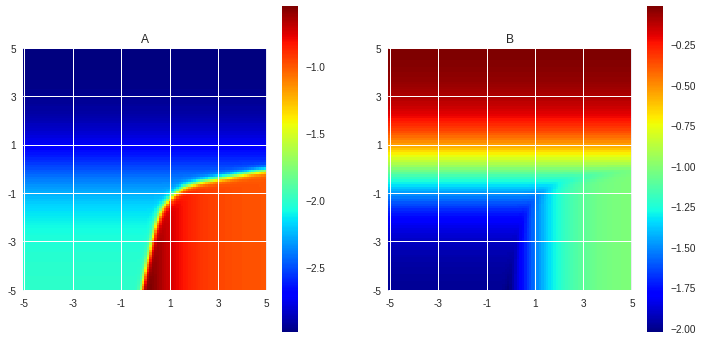

In [0]:
printagentaval()

In [0]:
min(1,n_inner_opt_b)

0

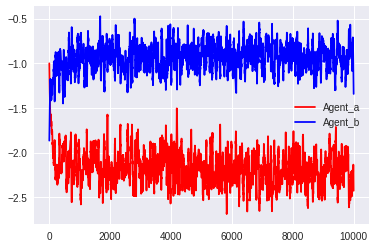

In [0]:
x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

plt.plot(savgol_filter(x_a, 51, 3), 'r', label='Agent_a')
plt.plot(savgol_filter(x_b, 51, 3), 'b', label='Agent_b')
plt.legend()
None

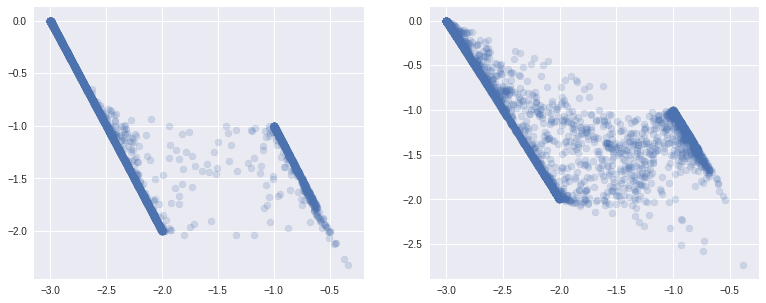

In [0]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(x_a[4000:],x_b[4000:],alpha = 0.2)

None

plt.subplot(1,2,2)
plt.scatter(x_a[:4000],x_b[:4000],alpha = 0.2)
None

agent_a ret  -2.1935387
agent_b ret  -0.9192518


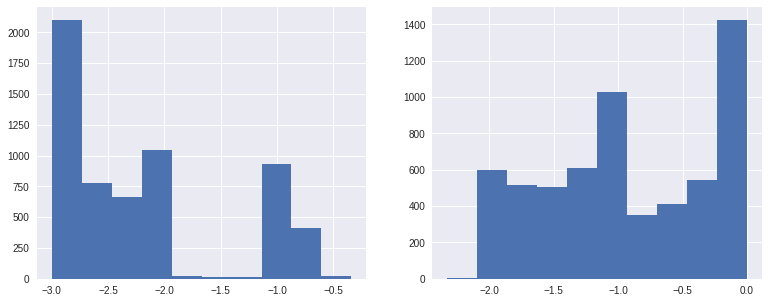

In [0]:
#With agent a learning

vals = 4000
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(x_a[vals:])
None

plt.subplot(1,2,2)
plt.hist(x_b[vals:])
None
print('agent_a ret ', np.mean(x_a[vals:]))
print('agent_b ret ', np.mean(x_b[vals:]))

agent_a ret  -2.1935387
agent_b ret  -0.9192518


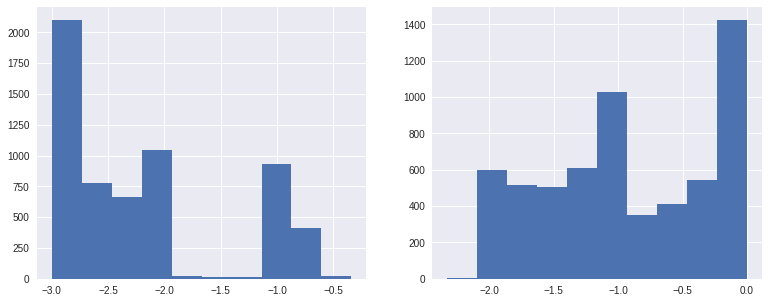

In [0]:
#No agent_a learning
vals = 4000
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(x_a[vals:])
None

plt.subplot(1,2,2)
plt.hist(x_b[vals:])
None
print('agent_a ret ', np.mean(x_a[vals:]))
print('agent_b ret ', np.mean(x_b[vals:]))

In [0]:
# take away: when B is LOLA, it can exploit agent A. But only if no stopgrad. 
# LOLA implementation
t=True; f=False
stop_grad = f
cooperative = f
torch.manual_seed(0)
learners = [0,1]
training_eps = 30000
n_inner_opt_a = 1 #1 == Agent A is LOLA
n_inner_opt_b = 1  #1 == Agent B is LOLA
lr = 0.1
lr_in = 1.
agent_a = nn.Sequential(
    nn.Linear(2, 1),
)

agent_b = nn.Sequential(
#     nn.Linear(2, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
    nn.Linear(2, 2)
)

payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)

for net in [agent_a, agent_b]:
  net.optimizer = SGD(net.parameters(), lr=lr)

# Make it cooperative if you want to
if cooperative:
  payout = (payout + torch.transpose( payout,0,1))/2

def get_return(agent_a, agent_b):
  weights_a = list(agent_a.parameters())[0][0]  # diff-able?
  if stop_grad:
    agent_a_in_b = weights_a.clone().detach()
  else:
    agent_a_in_b = weights_a
  pi_b = nn.Softmax(0)( agent_b(  agent_a_in_b ) ) # prob of agent B cooperating given agent A's policy 
  rews = torch.tensor([0.0, 0.0] )
  for u_b in [0,1]:
    p_u_b = pi_b[u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[u_b],weights_a[u_b] * 0)))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[0]+= prob * payout[ u_a, u_b]    
      rews[1]+= prob * payout[ u_b, u_a]
  return -rews


def LOLA_step(net1, net2_, agent_a, n_inner_opt):
    # net2_ = inner agent
    # net1 = outer agent
    # Inner optimization
    agent_b = (agent_a + 1) % 2 
    outer_agent = agent_a
    inner_agent = (outer_agent+ 1) % 2 
    nets = [ net1, net2_ ]
    net_a = nets[agent_a]
    net_b = nets[agent_b]
#     current = list(net2_.parameters())
#     print( "before lookahead", )
    for k in range(n_inner_opt):
        objective2 = get_return(net_a, net_b)[inner_agent]
#              param = param - lr_in * grad2[i]
#              print( "after lookahead", list(net2_.parameters())[i])
        differentiable_gradient_step(net2_, objective2, lr_in, inplace=True)
#     print( "after lookahead", list(net2_.parameters()))          
#     new = list(net2_.parameters())
#     print( agent_a)
#     for i in range( len( new)):
#       print( 'diffs', i, new[i]-current[i])
    # Outer optimization
    objective1 = get_return(net_a, net_b)[outer_agent]
    net1.optimizer.zero_grad()
    objective1.backward()
    net1.optimizer.step()
res = []   
for update in range(training_eps):
    net1 = agent_a
    net2 = agent_b
    net2_ = deepcopy(net2).to(device)
    net1_ = deepcopy(net1).to(device)
    LOLA_step(net1, net2_, 0, n_inner_opt_a)
    LOLA_step(net2, net1_, 1, n_inner_opt_b )   
    
    rews = -get_return(agent_a, agent_b)
    res.append( rews.data.numpy())
      
plt.plot(np.array(res)[:,0], 'r', label='Agent_a')
plt.plot(np.array(res)[:,1], 'b', label='Agent_b')
plt.legend()
None

KeyboardInterrupt: ignored

In [0]:
current

In [0]:
# Naive learning Implementation
stop_grad = False
cooperative = False
learners = [0,1]
training_eps = 10000

agent_a = init.normal_(torch.zeros(2, requires_grad=True ), std=1.0)
agent_b = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
)

payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)

# Make it cooperative if you want to
if cooperative:
  payout = (payout + torch.transpose( payout,0,1))/2

def get_return():
  if stop_grad:
    agent_a_in_b = agent_a.clone().detach()
  else:
    agent_a_in_b = agent_a
  pi_b = nn.Softmax(0)( agent_b(  agent_a_in_b ) ) # prop of agent B cooperating given agent A's policy 
  rews = torch.tensor([0.0, 0.0] )
  for u_b in [0,1]:
    p_u_b = pi_b[u_b]
    pi_a =  nn.Softmax(0)(torch.stack((agent_a[u_b],agent_a[u_b] * 0)))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[0]+= prob * payout[ u_a, u_b]    
      rews[1]+= prob * payout[ u_b, u_a]
  return rews


optimizers =  [ SGD([agent_a], lr=0.01),  SGD(agent_b.parameters(), lr=0.01)]
res = []
for i in range(training_eps):
    rews = get_return()
    res.append( rews.data.numpy())
    for a in learners:
      optimizers[a].zero_grad()
      (-rews[a]).backward(retain_graph=True)
      optimizers[a].step()
      
plt.plot(np.array(res)[:,0], 'r', label='Agent_a')
plt.plot(np.array(res)[:,1], 'b', label='Agent_b')
plt.legend()
None

In [0]:
for i, blub in enumerate(net2_.state_dict() ):
  print(blub)

In [0]:
agent_a = nn.Sequential(
    nn.Linear(2, 1),
)
# Todo: Think about stop-gradients in the graph. 
# Todo: Think about LOLA. 
# Todo: Write paper. 
# Todo Sören: Add LOLA :) 

list(agent_a.parameters())[0]

In [0]:
len(list(net2_.modules())[0]._parameters)

In [0]:
list(net2_.modules())

In [0]:
for layer in net2_.modules():
   if isinstance(layer, nn.Linear):
        layer.weight = torch.nn.Parameter(  layer.weight * 0)

In [0]:
for layer in net2_.modules():
   if isinstance(layer, nn.Linear):
    print(        layer.weight )